In [1]:
import sys
import os
import time
import glob
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
print('python version', sys.version_info)
print('tf version', tf.__version__, 'keras version', keras.__version__)

python version sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
tf version 2.2.0 keras version 2.3.0-tf


In [3]:
current_time_millis = lambda: int(round(time.time() * 1000))


# Datasource folders


In [4]:
YAHOO_DS="../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0"
DIRS = ['A1Benchmark', 'A2Benchmark','A3Benchmark', 'A4Benchmark']
DATA_FILE_EXTENSION = "*.csv"
Benchmark_dir  = YAHOO_DS + os.path.sep + DIRS[1] + os.path.sep 
Benchmark_dir

'../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/'

# Read data 

In [5]:
def read_data_set(file_name_to_read):
    dataset = pd.read_csv(file_name_to_read, usecols=[1])
    dataset = dataset.values
    dataset = dataset.astype('float32')    
    return dataset

In [6]:
def read_data(file, timeVariantColumns):
    df = pd.read_csv(file)
    return df[timeVariantColumns].values.astype('float64'), df.values.astype('float64')

# Prepare look back window based data set

In [7]:
def look_back_and_create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        dataX.append(a)
        dataY.append(dataset[i])
    return np.array(dataX), np.array(dataY)

Files in A1|2|3|4 benchmark folder

Test look back data preparation

In [8]:
Benchmark_dir  = YAHOO_DS + os.path.sep + DIRS[1] + os.path.sep 
benchmark_files = glob.glob(Benchmark_dir + DATA_FILE_EXTENSION, recursive=True)

print("{:d} .csv files in {:s}".format(len(benchmark_files), Benchmark_dir))
look_back=5
# do across all files in the benchmark. for now just the first one in glob list
for file_name in benchmark_files[:1]:
    print("Preparing file", file_name)
    tsData, data = read_data(file_name, ['value'])
    print("Shapes of data read from file: time variant data {}, full data {}".format(tsData.shape, data.shape))
    # look back and create reshaped dataset
    reshapedX, reshapedY = look_back_and_create_dataset(tsData, look_back)
    print("Look back reshapedX.shape", reshapedX.shape, "reshapedY.shape", reshapedY.shape)    
    reshapedXY = np.hstack((reshapedX, reshapedY))      
    print("ReshapedXY \n", reshapedXY[:10])

100 .csv files in ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/
Preparing file ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_10.csv
Shapes of data read from file: time variant data (1421, 1), full data (1421, 3)
Look back reshapedX.shape (1416, 5) reshapedY.shape (1416, 1)
ReshapedXY 
 [[127.69923816  23.06961419 246.1188566  295.93781848 264.6499858
  122.23286746]
 [ 23.06961419 246.1188566  295.93781848 264.6499858  122.23286746
  238.54006612]
 [246.1188566  295.93781848 264.6499858  122.23286746 238.54006612
  356.59069416]
 [295.93781848 264.6499858  122.23286746 238.54006612 356.59069416
  439.19625187]
 [264.6499858  122.23286746 238.54006612 356.59069416 439.19625187
  735.37467526]
 [122.23286746 238.54006612 356.59069416 439.19625187 735.37467526
  621.57485665]
 [238.54006612 356.59069416 439.19625187 735.37467526 621.57485665
  514.83835704]
 [356.59069416 439.1962518

# Prepare train and test splits

In [9]:
def split_data_set(dataset, split=0.67):
    train_size = int(len(dataset) * split)
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
    return train, test

In [10]:
def get_train_test_data_from_file(file_name, timeVariantColumns, split=.8, look_back=1):    
    tsData, data = read_data(file_name, timeVariantColumns)    
    reshapedX, reshapedY = look_back_and_create_dataset(tsData, look_back)         
    Xtrain, Xtest = split_data_set(reshapedX, split)
    Ytrain, Ytest = split_data_set(reshapedY, split) 
    return data, reshapedX, reshapedY, Xtrain, Ytrain, Xtest, Ytest  

Test training, test split

In [11]:
# do across all files in the benchmark. for now just the first one in glob list
Benchmark_dir  = YAHOO_DS + os.path.sep + DIRS[1] + os.path.sep 
benchmark_files = glob.glob(Benchmark_dir + DATA_FILE_EXTENSION, recursive=True)
timeVariantColumns = ['value']
split = 0.8
look_back = 24
for data_file in benchmark_files[:1]:
    print('File Name : ', data_file)
    data, reshapedX, reshapedY, Xtrain, Ytrain, Xtest, Ytest = get_train_test_data_from_file(data_file, timeVariantColumns, split, look_back)    
    print("Shapes: Original data {}, reshapedX {}, reshapedY {}".format(data.shape, reshapedX.shape, reshapedY.shape))
    print("Shapes: Xtrain {}, Ytrain {}, Xtest {}, Ytest {}".format(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape))
    
#     print("Xtrain ... first 5\n {} \n Ytrain ... first 5 \n {}".format(Xtrain[:5], Ytrain[:5]))
#     print("Xtest ... first 5\n {} \n Ytest ... first 5 \n {}".format(Xtest[:5], Ytest[:5]))
    

File Name :  ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_10.csv
Shapes: Original data (1421, 3), reshapedX (1397, 24), reshapedY (1397, 1)
Shapes: Xtrain (1117, 24), Ytrain (1117, 1), Xtest (280, 24), Ytest (280, 1)


# Train model

In [12]:
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(0,1))
#     scaler = StandardScaler()
    # fit normalization scaler to train only, but transform both train and test using the scaler fit to train
    scaler.fit(train)
    return scaler, scaler.transform(train), scaler.transform(test)

In [13]:
def train(X, Y, verbose = False ):
    model = Sequential()
    model.add(Dense(8, input_shape=X.shape[1:], activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')    
    model.fit(X, Y, epochs=25, batch_size=1000, verbose=verbose)
    return model

In [14]:
def predict(model, X):
    return model.predict(X)

In [15]:
def evaluate_model(model, X, Y):
    score = model.evaluate(X, Y, verbose=0)
    return score, sqrt(score)

In [16]:
def plot_actuals_vs_predictions(Y, YtrainPredicted, YtestPredicted, look_back):
    trainPredictPlot = np.empty_like(Y)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[:len(YtrainPredicted), :] = YtrainPredicted
    
    testPredictPlot = np.empty_like(Y)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(YtrainPredicted):len(Y), :] = YtestPredicted    

    #Now Plot
    plt.figure(figsize=(40,10))
    plt.plot(testPredictPlot, label ='Test Prediction')
    plt.plot(trainPredictPlot, label ='Train Prediction')
    plt.plot(Y, label = 'Actual')
    plt.legend(("Test Prediction", "Train Prediction", "Actual"), loc=3)
    plt.show()

In [17]:
def get_deviations(model, X, Y):
    scalerX = MinMaxScaler(feature_range=(0,1))
    scalerY = MinMaxScaler(feature_range=(0,1))    
    deviations = np.absolute(scalerY.fit_transform(Y) - model.predict(scalerX.fit_transform(X)))
    print("Deviation Min {}, Max {}".format(np.amin(deviations, axis=0), np.amax(deviations, axis=0)))    
    return deviations

In [18]:
def get_records_above_deviation_threshold(model, X, Y, threshold=0.1):
    deviations = get_deviations(model, X, Y)
    labels = (deviations > threshold).astype('int')
    print("Deviation > {} is_anomaly labels in data {}".format(threshold, np.unique(labelsThreshold, return_counts = True)))
    return labels

In [19]:
def get_records_above_deviation_pctile(model, X, Y, pctile=95):
    deviations = get_deviations(model, X, Y)
    pctileDeviationValue = np.percentile(deviations, q=pctile, axis=0)
    print("Deviation {}th pctile {}".format(pctile, pctileDeviationValue ))
    labels = (deviations > pctileDeviationValue).astype('int')
    print("Deviation > {}th pctile is_anomaly labels in data {}".format(pctile, np.unique(labels, return_counts = True)))
    return labels

In [20]:
def get_classification_metrics(actual, predicted):
    return confusion_matrix(actual, predicted), precision_score(actual, predicted), recall_score(actual, predicted), f1_score(actual, predicted)

File Name :  ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_10.csv
Shapes: Xtrain (1117, 24), Ytrain (1117, 1), Xtest (280, 24), Ytest (280, 1)
Train Score: 0.00855 MSE 0.09245 RMSE
Test Score: 0.00680 MSE 0.08247 RMSE


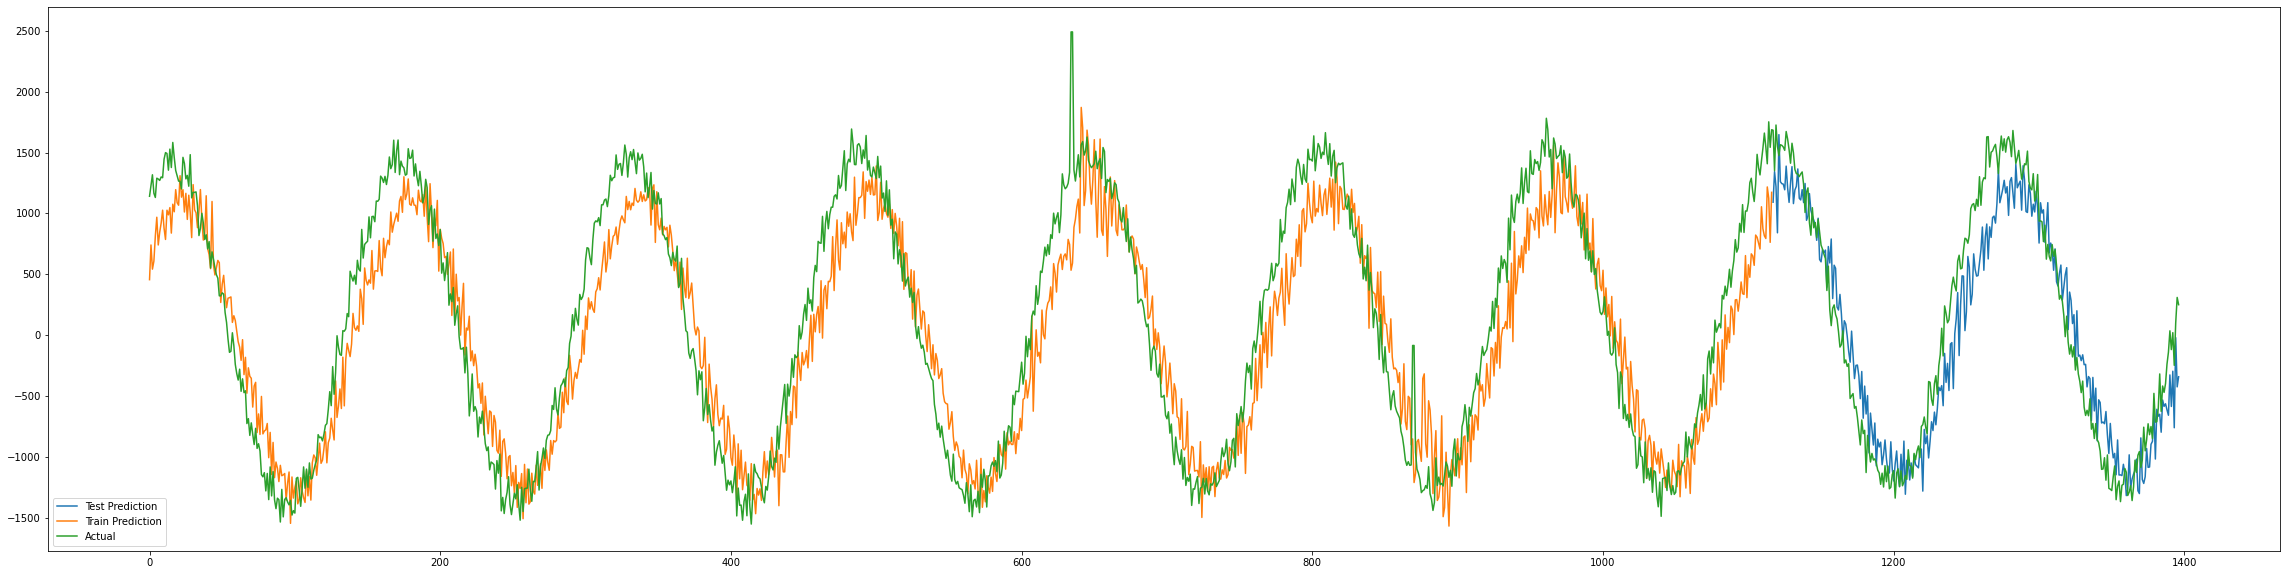

Deviation Min [0.00019762], Max [0.48424554]
Deviation 99.7th pctile [0.24829319]
Deviation > 99.7th pctile is_anomaly labels in data (array([0, 1]), array([1392,    5]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1391    2]
 [   1    3]]
precision 0.60000, recall 0.75000, f1 0.66667
Time to train: 574 ms
File Name :  ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_47.csv
Shapes: Xtrain (1117, 24), Ytrain (1117, 1), Xtest (280, 24), Ytest (280, 1)
Train Score: 0.00939 MSE 0.09689 RMSE
Test Score: 0.00514 MSE 0.07171 RMSE


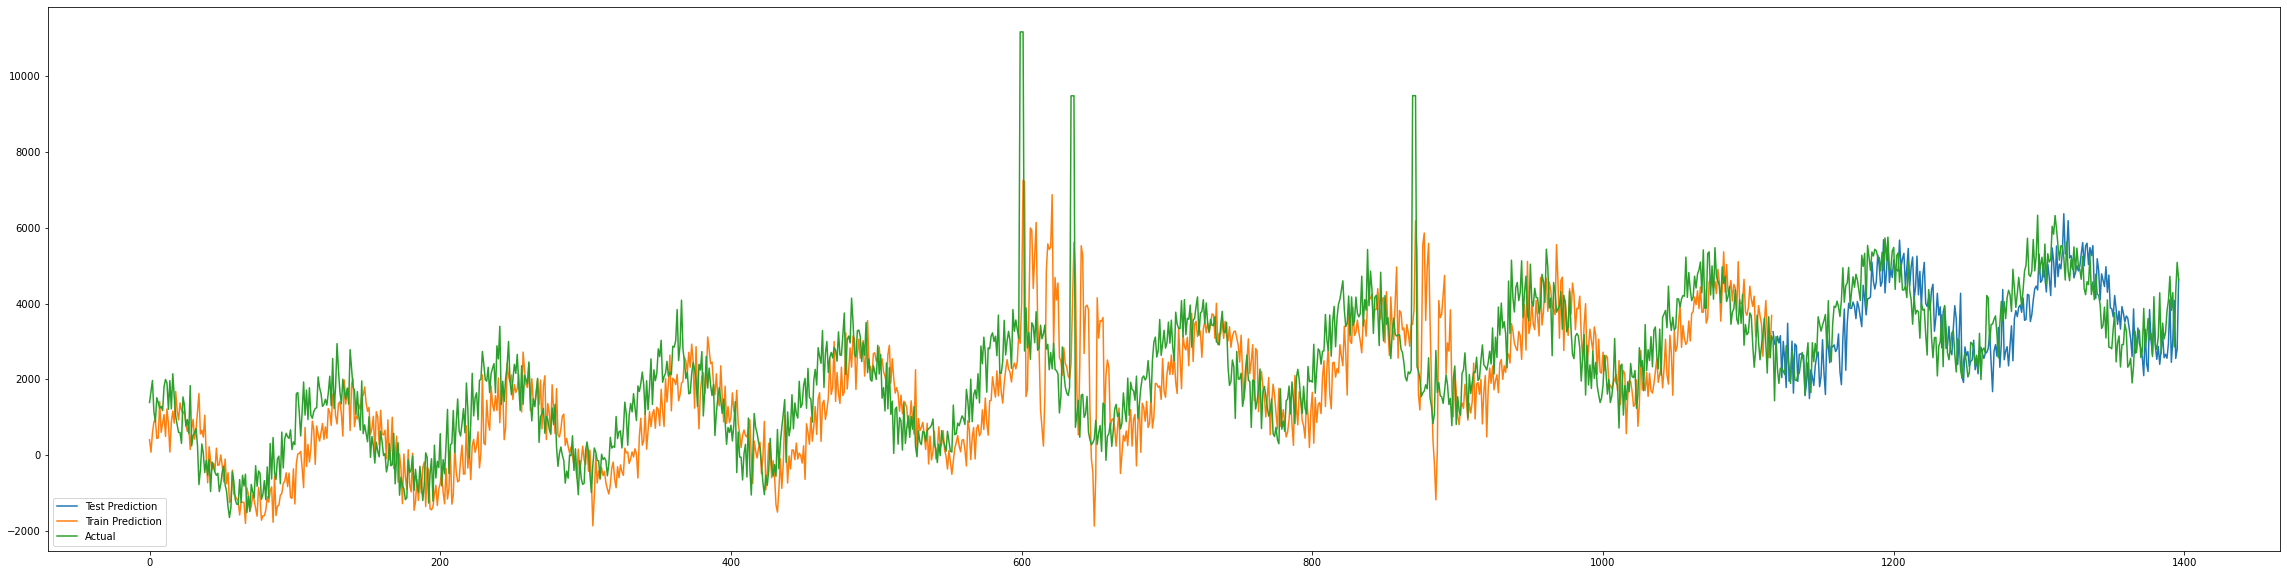

Deviation Min [2.90170234e-05], Max [0.64109483]
Deviation 99.7th pctile [0.43713633]
Deviation > 99.7th pctile is_anomaly labels in data (array([0, 1]), array([1392,    5]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   4    5]]
precision 1.00000, recall 0.55556, f1 0.71429
Time to train: 663 ms


In [23]:
# do across all files in the benchmark. for now just the first one in glob list
Benchmark_dir  = YAHOO_DS + os.path.sep + DIRS[1] + os.path.sep 
benchmark_files = glob.glob(Benchmark_dir + DATA_FILE_EXTENSION, recursive=True)
timeVariantColumns = ['value']
threshold = 0.3
pctile = 99.7
split = 0.8
look_back = 24

metricsMap = {}
for data_file in benchmark_files[:2]:
    metrics = {}
    print('File Name : ', data_file)
    data, reshapedX, reshapedY, Xtrain, Ytrain, Xtest, Ytest = get_train_test_data_from_file(data_file, timeVariantColumns, split, look_back)
    print("Shapes: Xtrain {}, Ytrain {}, Xtest {}, Ytest {}".format(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape))
    scalerX, scaledXtrain, scaledXtest = scale(Xtrain, Xtest)
    scalerY, scaledYtrain, scaledYtest = scale(Ytrain, Ytest)
    start_millis = current_time_millis()
    model = train(X = scaledXtrain, Y = scaledYtrain, verbose = False)
    end_millis = current_time_millis() 
    trainMSE, trainRMSE = evaluate_model(model = model, X = scaledXtrain, Y = scaledYtrain)
    print("Train Score: {0:.5f} MSE {1:.5f} RMSE".format(trainMSE, trainRMSE))
    testMSE, testRMSE = evaluate_model(model = model, X = scaledXtest, Y= scaledYtest)
    print("Test Score: {0:.5f} MSE {1:.5f} RMSE".format(testMSE, testRMSE))
    
    YtrainPredicted = predict(model = model, X = scaledXtrain)
    YtestPredicted = predict(model = model, X = scaledXtest)
    
    plot_actuals_vs_predictions(reshapedY, scalerY.inverse_transform(YtrainPredicted), scalerY.inverse_transform(YtestPredicted), look_back)
            
    # get deviations for whole dataset and id records with deviations > pctile threshold and asign an is_anomaly label
    labels = get_records_above_deviation_pctile(model, reshapedX, reshapedY, pctile)
    
    # actual is_anomaly labels in dataset
    actualLabels = (data[look_back:, data.shape[1] - 1] != 0.0).astype('int')    
    print("Actual is_anomaly labels in data", np.unique(actualLabels, return_counts = True))
        
    # Compare calculated labels and actual labels to find TP, TN, FP, FN and F1, confusion matrix
    conf_matrix, prec, recall, f1 = get_classification_metrics(actualLabels, labels)
    print("Confusion matrix \n{0}\nprecision {1:.5f}, recall {2:.5f}, f1 {3:.5f}".format(conf_matrix, prec, recall, f1))
    print("Time to train: {} ms".format(end_millis - start_millis))
    metrics['traintime'] = end_millis - start_millis
    metrics['conf_matrix'] = conf_matrix
    metrics['precision'] = prec
    metrics['recall'] = recall
    metrics['f1'] = f1
    metricsMap[data_file] = metrics


In [24]:
precisions=[]
recalls=[]
f1s=[]
times = []
for v in metricsMap.values():
    precisions.append(v['precision'])
    recalls.append(v['recall'])
    f1s.append(v['f1'])
    times.append(v['traintime'])
avg_prec = np.average(np.array(precisions))
avg_recall = np.average(np.array(recalls))
avg_f1 = np.average(np.array(f1s))
avg_time = np.average(np.array(times))
print("Avg precision {0:.5f} recall {1:.5f} f1 {2:.5f} time to train {3:.2f} ms".format(avg_prec, avg_recall, avg_f1, avg_time))

Avg precision 0.80000 recall 0.65278 f1 0.69048 time to train 618.50 ms
